# Gate based workflow

This notebook shows an example of how a gate based computation (in this case using `qiskit`) could be integrated into `qse`.

In [1]:
import qse
import numpy as np

from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import efficient_su2
from scipy.optimize import minimize
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from qiskit.circuit import QuantumCircuit

## Step 1: Create qbits object

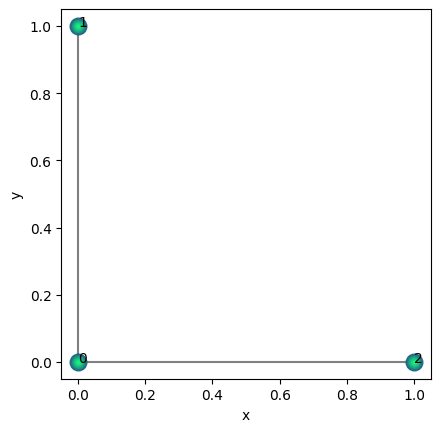

In [2]:
positions = np.array([
    [0., 0., 0.],
    [0., 1., 0.],
    [1., 0., 0.],
    ])

qbits = qse.Qbits(positions=positions)
qbits.draw(show_labels=True, radius="nearest")

# Step 2: Define a distance function to create an interaction Hamiltonian that's based on the geometry of the qubits.

In [3]:
def distance_func(distance, tolerance=0.01):
    """
    Simple distance function that only includes nearest neighbours.
    
    This function returns a coefficient of 1.0 if the input distance is approximately 1.0
    (within a specified tolerance), otherwise it returns 0.0.
    """
    if np.abs(distance-1) < tolerance:
        return 1.
    return 0.

In [4]:
# simple ZZ coupling
coupling = qbits.compute_interaction_hamiltonian(distance_func, "Z")

SparsePauliOp([i.to_str() for i in coupling], [i.coef for i in coupling])

SparsePauliOp(['ZZI', 'ZIZ'],
              coeffs=[1.+0.j, 1.+0.j])

In [5]:
# heisenberg model
coupling = qbits.compute_interaction_hamiltonian(distance_func, "X") + qbits.compute_interaction_hamiltonian(distance_func, "Y") + qbits.compute_interaction_hamiltonian(distance_func, "Z")

SparsePauliOp([i.to_str() for i in coupling], [i.coef for i in coupling])

SparsePauliOp(['XXI', 'XIX', 'YYI', 'YIY', 'ZZI', 'ZIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])

In [6]:
# simple ZZ coupling
coupling = qbits.compute_interaction_hamiltonian(distance_func, "Z")

hamiltonian = SparsePauliOp([i.to_str() for i in coupling], [i.coef for i in coupling])

## Step 3: Run in qiskit

In [7]:
ansatz = efficient_su2(qbits.nqbits, reps=1)

In [8]:
def compute_expectation(params):
    """Compute the expectation value of a quantum operator using a statevector simulator."""
    estimator = StatevectorEstimator()

    pub = (ansatz, hamiltonian, params)
    job = estimator.run([pub])

    return job.result()[0].data.evs

def run_sampler(params, shots=1000):
    """Sample a circuit using a statevector simulator."""
    sampler = StatevectorSampler()

    circuit = QuantumCircuit(ansatz.num_qubits)
    circuit.append(ansatz, range(ansatz.num_qubits))
    circuit.measure_all()

    pub = (circuit, params)
    job = sampler.run([pub], shots=shots)

    return job.result()[0].data.meas.get_counts()

In [9]:
x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

cost_hist = []
opt_result = minimize(
    compute_expectation, x0, method="BFGS", 
    callback=lambda intermediate_result: cost_hist.append(intermediate_result.fun)
    )


In [10]:
opt_result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.9999999998514726
        x: [ 3.142e+00  4.256e-05  1.335e+00  2.738e+00  2.870e+00
             3.142e+00  2.291e-07  4.623e-05  1.335e+00  2.106e+00
             2.334e+00  5.895e+00]
      nit: 13
      jac: [ 9.686e-07 -7.451e-07  7.361e-06  2.980e-08 -2.980e-08
            -3.844e-06  2.086e-07  6.318e-06 -7.302e-06 -5.960e-08
             2.980e-08  2.980e-08]
 hess_inv: [[ 4.814e-01 -6.394e-03 ...  8.469e-07  1.000e-05]
            [-6.394e-03  7.359e+00 ... -6.725e-06 -4.386e-05]
            ...
            [ 8.469e-07 -6.725e-06 ...  1.000e+00  7.261e-10]
            [ 1.000e-05 -4.386e-05 ...  7.261e-10  1.000e+00]]
     nfev: 195
     njev: 15

In [11]:
samples = run_sampler(opt_result.x, shots=1000)
samples

{'011': 1000}

## Step 4: Visualize results in qse

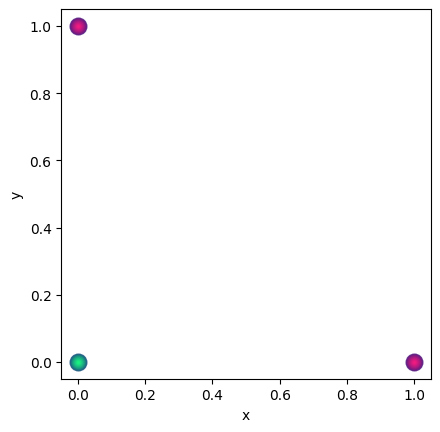

In [12]:
qbits.draw(colouring=list(samples.keys())[0])